In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Adi and Lavanya code

Using Keras 1.2, And tensor Flow 1.x

In [ ]:
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Input
from keras.layers import Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, Reshape, ZeroPadding2D
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import keras
from keras.layers import Layer
from keras.layers import Activation, Dense



In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#De-Pickling Data with encoding latin1
with open("/content/drive/MyDrive/Colab Notebooks/DATA/Lavanya/RML2016.10a_dict.pickle.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding='latin1')

In [ ]:
classes = ['32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', #1
 '8ASK', 'BPSK','8PSK', 'AM-SSB-SC', '4ASK', '16PSK', '64APSK', '128QAM', '128APSK','AM-DSB-SC', #2 
'AM-SSB-WC', '64QAM', 'QPSK', '256QAM','AM-DSB-WC','OOK','16QAM']


In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
np.random.seed(2016)  # 对预处理好的数据进行打包，制作成投入网络训练的格式，并进行one-hot编码
n_examples = X.shape[0]
n_train = n_examples * 0.5  # 对半
train_idx = np.random.choice(range(0, n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0, n_examples)) - set(train_idx))  # label
X_train = X[train_idx]
X_test = X[test_idx]

In [ ]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy) + 1])
    yy1[np.arange(len(yy)), yy] = 1
    return yy1


In [ ]:
trainy = list(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_train = to_onehot(trainy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [ ]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods
# %%
dr = 0.5  # dropout rate (%) 卷积层部分  https://keras-cn.readthedocs.io/en/latest/layers/convolutional_layer/#conv2d
#model = models.Sequential()  # 这里使用keras的序贯模型  https://keras-cn.readthedocs.io/en/latest/models/sequential/
# Reshape [N,2,128] to [N,2,128,1] on input

(110000, 2, 128) [2, 128]


In [ ]:
maxlen = 128 # change subnyq sampling rate HERE.

def gendata(fp, nsamples):
    global snrs, mods, train_idx, test_idx, lbl
    with open(fp, 'rb') as f:
      Xd = pickle.load(f, encoding='latin1')
    
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    X = []  
    lbl = []
    for mod in mods:
      for snr in snrs:
        X.append(Xd[(mod, snr)])
        for i in range(Xd[(mod, snr)].shape[0]):
          lbl.append((mod, snr))
    X = np.vstack(X)
    
    print('Length of lbl', len(lbl))
    print('shape of X', X.shape)

    np.random.seed(2016)
    n_example = X.shape[0]
    n_train = n_example * 0.5
    train_idx = np.random.choice(range(0,n_example), size=int(n_train), replace=False)
    test_idx = list(set(range(0, n_example)) - set(train_idx))
    X_train = X[train_idx]
    X_test =  X[test_idx]
    
    def to_onehot(vec):
      vec_hot = np.zeros([len(vec), max(vec) + 1])
      vec_hot[np.arange(len(vec)), vec] = 1
      return vec_hot
    
    Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
    Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

    return (X_train,X_test,Y_train,Y_test)


def norm_pad_zeros(X_train,nsamples):
    print ("Pad:", X_train.shape)
    for i in range(X_train.shape[0]):
        X_train[i,:,0] = X_train[i,:,0]/la.norm(X_train[i,:,0],2)
    return X_train


def to_amp_phase(X_train,X_test,nsamples):
    X_train_cmplx = X_train[:,0,:] + 1j* X_train[:,1,:]
    X_test_cmplx = X_test[:,0,:] + 1j* X_test[:,1,:]
    
    X_train_amp = np.abs(X_train_cmplx)
    X_train_ang = np.arctan2(X_train[:,1,:],X_train[:,0,:])/np.pi
    
    X_train_amp = np.reshape(X_train_amp,(-1,1,nsamples))
    X_train_ang = np.reshape(X_train_ang,(-1,1,nsamples))
   
    X_train = np.concatenate((X_train_amp,X_train_ang), axis=1) 
    X_train = np.transpose(np.array(X_train),(0,2,1))
    
    X_test_amp = np.abs(X_test_cmplx)
    X_test_ang = np.arctan2(X_test[:,1,:],X_test[:,0,:])/np.pi
    
    
    X_test_amp = np.reshape(X_test_amp,(-1,1,nsamples))
    X_test_ang = np.reshape(X_test_ang,(-1,1,nsamples))
    
    X_test = np.concatenate((X_test_amp,X_test_ang), axis=1) 
    X_test = np.transpose(np.array(X_test),(0,2,1))
    return (X_train, X_test)

In [ ]:
def getFontColor(value):
    if np.isnan(value):
        return "black"
    elif value < 0.2:
        return "black"
    else:
        return "white"

def getConfusionMatrixPlot(true_labels, predicted_labels):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm,2)
    print(cm)

    print()
    # create figure
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    res = ax.imshow(cm, cmap=plt.cm.binary,
                    interpolation='nearest', vmin=0, vmax=1)

    # add color bar
    plt.colorbar(res)

    # annotate confusion entries
    width = len(cm)
    height = len(cm[0])

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',
                        verticalalignment='center', color=getFontColor(cm[x][y]))

    # add genres as ticks
    alphabet = mods 
    plt.xticks(range(width), alphabet[:width], rotation=30)
    plt.yticks(range(height), alphabet[:height])
    return plt

In [ ]:
xtrain1,xtest1,ytrain1,ytest1= gendata("/content/drive/MyDrive/Colab Notebooks/DATA/Lavanya/RML2016.10a_dict.pickle.pkl",maxlen)

print('using version 10a dataset')
test_SNRs = map(lambda x: lbl[x][1], test_idx)
train_SNRs = map(lambda x: lbl[x][1], train_idx)
train_snr = lambda snr: xtrain1[np.where(np.array(train_SNRs)==snr)]
test_snr = lambda snr: ytrain1[np.where(np.array(train_SNRs)==snr)]

Length of lbl 220000
shape of X (220000, 2, 128)
using version 10a dataset


In [ ]:
print('length of X before to_amp_phase:', xtrain1.shape)
xtrain1,xtest1 = to_amp_phase(xtrain1,xtest1,maxlen)
print('length of X after to_amp_phase:', xtrain1.shape)

length of X before to_amp_phase: (110000, 2, 128)
length of X after to_amp_phase: (110000, 128, 2)


In [ ]:
xtrain1 = xtrain1[:,:maxlen,:]
xtest1 = xtest1[:,:maxlen,:]

In [ ]:
from numpy import linalg as la 

In [ ]:
xtrain1 = norm_pad_zeros(xtrain1,maxlen)
xtest1 = norm_pad_zeros(xtest1,maxlen)

Pad: (110000, 128, 2)
Pad: (110000, 128, 2)


In [ ]:
Y_train = np.reshape(ytrain1,(-1,10))
Y_test = np.reshape(ytest1,(-1,10))

In [ ]:
X_train = xtrain1
X_test = xtest1
print(X_train.shape,Y_train.shape)

(110000, 128, 2) (121000, 10)


In [ ]:
print("--"*50)
print("Training data:",X_train.shape)
print("Training labels:",Y_train.shape)
print("Testing data",X_test.shape)
print("Testing labels",Y_test.shape)
print("--"*50)

----------------------------------------------------------------------------------------------------
Training data: (110000, 128, 2)
Training labels: (121000, 10)
Testing data (110000, 128, 2)
Testing labels (121000, 10)
----------------------------------------------------------------------------------------------------


In [ ]:
import keras.backend as K

In [ ]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp, snrs)
classes = mods

(110000, 128, 2) [128, 2] [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [ ]:
model = models.Sequential()
model.add(keras.layers.LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.9, input_shape = in_shp, name='lstm1'))
model.add(keras.layers.LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.9, name='lstm2'))
model.add(Flatten())
model.add(Dense(len(classes), activation='softmax', kernel_initializer='he_normal', name='dense'))
model.compile(loss='categorical_crossentropy', optimizer='Adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 128, 128)          67072     
_________________________________________________________________
lstm2 (LSTM)                 (None, 128, 128)          131584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 11)                180235    
Total params: 378,891
Trainable params: 378,891
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 100
batch_size = 1024  # training batch size

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
  for snr in snrs:
    X.append(Xd[(mod, snr)])
    for i in range(Xd[(mod, snr)].shape[0]):
      lbl.append((mod, snr))
X = np.vstack(X)

In [ ]:
def to_onehot(vec):
    vec_hot = np.zeros([len(vec), max(vec) + 1])
    vec_hot[np.arange(len(vec)), vec] = 1
    return vec_hot


Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [ ]:
filepath = 'lstm2_multigpu_0.6.wts.h5' 
  
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0018),
              metrics=['accuracy'])
# we re-load the best weights once training is finished

history = model.fit(
    X_train, Y_train,
    batch_size=batch_size, epochs=nb_epoch,
    verbose=1, validation_data=(X_test, Y_test),
    callbacks = [keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                 keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

Epoch 1/100
108/108 [==============================] - 100s 893ms/step - loss: 2.0921 - accuracy: 0.2182 - val_loss: 2.0114 - val_accuracy: 0.2573
Epoch 2/100
108/108 [==============================] - 96s 886ms/step - loss: 2.0162 - accuracy: 0.2516 - val_loss: 1.9241 - val_accuracy: 0.2701
Epoch 3/100
108/108 [==============================] - 97s 897ms/step - loss: 1.9492 - accuracy: 0.2739 - val_loss: 1.8598 - val_accuracy: 0.2949
Epoch 4/100
108/108 [==============================] - 96s 887ms/step - loss: 1.8916 - accuracy: 0.2944 - val_loss: 1.8129 - val_accuracy: 0.3126
Epoch 5/100
108/108 [==============================] - 95s 877ms/step - loss: 1.8466 - accuracy: 0.3084 - val_loss: 1.7575 - val_accuracy: 0.3390
Epoch 6/100
108/108 [==============================] - 95s 882ms/step - loss: 1.8033 - accuracy: 0.3189 - val_loss: 1.7295 - val_accuracy: 0.3409
Epoch 7/100
108/108 [==============================] - 95s 881ms/step - loss: 1.7756 - accuracy: 0.3273 - val_loss: 1.8202 

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print (score)

[1.539778232574463, 0.4207727313041687]


In [ ]:
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Input
from keras.layers import Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, Reshape, ZeroPadding2D
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import keras
from keras.layers import Layer
from keras.layers import Activation, Dense


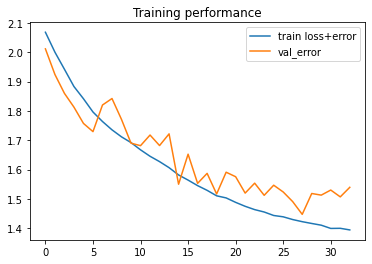

In [ ]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

In [ ]:
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
from tensorflow.keras import layers
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pickle, random, sys, keras
import h5py

# import modules
from IPython.display import display, clear_output
import numpy as np
import os
# import deep learning libraries
import os
import keras
import pickle
from keras import layers
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Dropout, Add, Dense, Reshape, Activation
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D

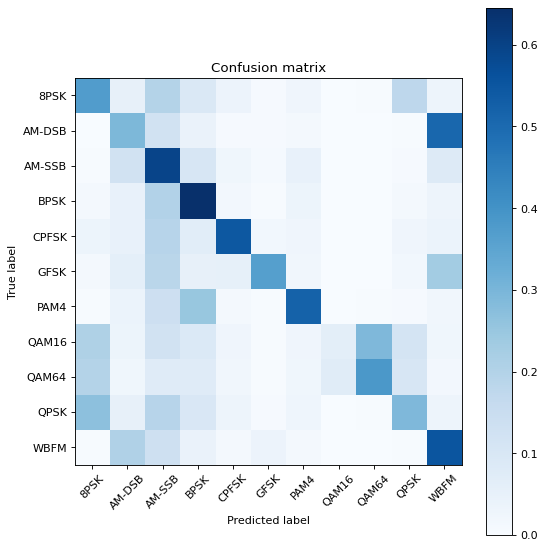

In [ ]:
figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='black')
plot_confusion_matrix(confnorm, labels=classes)

In [ ]:
acc = {}
for snr in snrs:
  # extract classes @ SNR
  test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
  test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
  test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]
  # estimate classes
  test_Y_i_hat = model.predict(test_X_i)
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])
  for i in range(0,test_X_i.shape[0]):
    j = list(test_Y_i[i,:]).index(1)
    k = int(np.argmax(test_Y_i_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

  #plt.figure()
  #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  print("SNR: ",snr, " Overall Accuracy: ", cor / (cor + ncor))
  acc[snr] = 1.0 * cor / (cor + ncor)

SNR:  -20  Overall Accuracy:  0.09844464775846294
SNR:  -18  Overall Accuracy:  0.0930063578564941
SNR:  -16  Overall Accuracy:  0.10148335745296672
SNR:  -14  Overall Accuracy:  0.11277517141826056
SNR:  -12  Overall Accuracy:  0.1422060164083865
SNR:  -10  Overall Accuracy:  0.17949173627154788
SNR:  -8  Overall Accuracy:  0.22156898769061179
SNR:  -6  Overall Accuracy:  0.31359970674486803
SNR:  -4  Overall Accuracy:  0.43179297597042515
SNR:  -2  Overall Accuracy:  0.5625907111756169
SNR:  0  Overall Accuracy:  0.6122262773722628
SNR:  2  Overall Accuracy:  0.6205016357688113
SNR:  4  Overall Accuracy:  0.6154552129221733
SNR:  6  Overall Accuracy:  0.6176895306859206
SNR:  8  Overall Accuracy:  0.6102795311091073
SNR:  10  Overall Accuracy:  0.6167577413479053
SNR:  12  Overall Accuracy:  0.6145210936085461
SNR:  14  Overall Accuracy:  0.6224395644952944
SNR:  16  Overall Accuracy:  0.6094117647058823
SNR:  18  Overall Accuracy:  0.6223222322232224


{-20: 0.09844464775846294, -18: 0.0930063578564941, -16: 0.10148335745296672, -14: 0.11277517141826056, -12: 0.1422060164083865, -10: 0.17949173627154788, -8: 0.22156898769061179, -6: 0.31359970674486803, -4: 0.43179297597042515, -2: 0.5625907111756169, 0: 0.6122262773722628, 2: 0.6205016357688113, 4: 0.6154552129221733, 6: 0.6176895306859206, 8: 0.6102795311091073, 10: 0.6167577413479053, 12: 0.6145210936085461, 14: 0.6224395644952944, 16: 0.6094117647058823, 18: 0.6223222322232224}


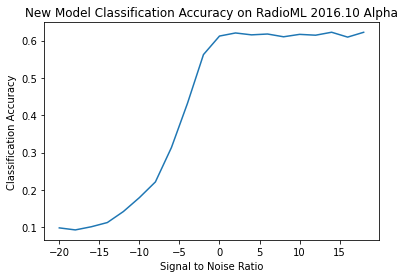

In [ ]:
print(acc)
fd = open('results_cnn_d0.5.dat','wb')
pickle.dump( ("CNN", 0.5, acc) , fd )

# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("New Model Classification Accuracy on RadioML 2016.10 Alpha")
plt.show()

# Updated(DeviJi)

In [ ]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib
matplotlib.use('Agg')
import pickle
import matplotlib.pyplot as plt
import sys
import operator
from numpy import linalg as la 
from math import ceil
##from keras.utils import multi_gpu_model
from keras import backend as K

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import modules
from IPython.display import display, clear_output
import numpy as np
import os
# import deep learning libraries
import os
import keras
import pickle
from keras import layers
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Dropout, Add, Dense, Reshape, Activation
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D

In [ ]:
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
from tensorflow.keras import layers
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pickle, random, sys, keras
import h5py

In [ ]:
maxlen = 128 # change subnyq sampling rate HERE.

def gendata(fp, nsamples):
    global snrs, mods, train_idx, test_idx, lbl
    with open(fp, 'rb') as f:
      Xd = pickle.load(f, encoding='latin1')
    
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    X = []  
    lbl = []
    for mod in mods:
      for snr in snrs:
        X.append(Xd[(mod, snr)])
        for i in range(Xd[(mod, snr)].shape[0]):
          lbl.append((mod, snr))
    X = np.vstack(X)
    
    print('Length of lbl', len(lbl))
    print('shape of X', X.shape)

    np.random.seed(2016)
    n_example = X.shape[0]
    n_train = n_example * 0.5
    train_idx = np.random.choice(range(0,n_example), size=int(n_train), replace=False)
    test_idx = list(set(range(0, n_example)) - set(train_idx))
    X_train = X[train_idx]
    X_test =  X[test_idx]
    
    def to_onehot(vec):
      vec_hot = np.zeros([len(vec), max(vec) + 1])
      vec_hot[np.arange(len(vec)), vec] = 1
      return vec_hot
    
    Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
    Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

    return (X_train,X_test,Y_train,Y_test)

def norm_pad_zeros(X_train,nsamples):
    print ("Pad:", X_train.shape)
    for i in range(X_train.shape[0]):
        X_train[i,:,0] = X_train[i,:,0]/la.norm(X_train[i,:,0],2)
    return X_train


def to_amp_phase(X_train,X_test,nsamples):
    X_train_cmplx = X_train[:,0,:] + 1j* X_train[:,1,:]
    X_test_cmplx = X_test[:,0,:] + 1j* X_test[:,1,:]
    
    X_train_amp = np.abs(X_train_cmplx)
    X_train_ang = np.arctan2(X_train[:,1,:],X_train[:,0,:])/np.pi
  

    X_train_amp = np.reshape(X_train_amp,(-1,1,nsamples))
    X_train_ang = np.reshape(X_train_ang,(-1,1,nsamples))
   
    X_train = np.concatenate((X_train_amp,X_train_ang), axis=1) 
    X_train = np.transpose(np.array(X_train),(0,2,1))
    
    X_test_amp = np.abs(X_test_cmplx)
    X_test_ang = np.arctan2(X_test[:,1,:],X_test[:,0,:])/np.pi
    
    
    X_test_amp = np.reshape(X_test_amp,(-1,1,nsamples))
    X_test_ang = np.reshape(X_test_ang,(-1,1,nsamples))
    
    X_test = np.concatenate((X_test_amp,X_test_ang), axis=1) 
    X_test = np.transpose(np.array(X_test),(0,2,1))

    X_train = np.transpose(X_train,axes=(0,2,1))
    X_test = np.transpose(X_test,axes=(0,2,1))
    return (X_train, X_test)


In [ ]:
xtrain1,xtest1,ytrain1,ytest1= gendata("/content/drive/My Drive/Colab Notebooks/DATA/Lavanya/RML2016.10a_dict.pickle.pkl",maxlen)
print(xtrain1.shape)
print(ytrain1.shape)                
#print('using version 10a dataset')
#test_SNRs = map(lambda x: lbl[x][1], test_idx)
#train_SNRs = map(lambda x: lbl[x][1], train_idx)
#train_snr = lambda snr: xtrain1[np.where(np.array(train_SNRs)==snr)]
#test_snr = lambda snr: ytrain1[np.where(np.array(train_SNRs)==snr)]


In [ ]:
print('length of X before to_amp_phase:', xtrain1.shape)
X_train_ap,X_test_ap = to_amp_phase(xtrain1,xtest1,maxlen)
print('length of X after to_amp_phase:', xtrain1.shape)
X_train_iq, Y_train_iq = xtrain1, ytrain1
X_test_iq, Y_test_iq = xtest1, ytest1
Y_train_ap, Y_test_ap = ytrain1, ytest1

In [ ]:
print("--"*50)
print("Training data for 1st Stream: ",X_train_ap.shape)
print("Training labels for 1st Stream: ",Y_train_ap.shape)
print("Testing data for 1st Stream: ",X_test_ap.shape)
print("Testing labels for 1st Stream: ",Y_test_ap.shape)
print("--"*50)
print("Training data for 2nd Stream: ",X_train_iq.shape)
print("Training labels for 2nd Stream :",Y_train_iq.shape)
print("Testing data for 2nd Stream :  ",X_test_iq.shape)
print("Testing labels for 2nd Stream : ",Y_test_iq.shape)
print("--"*50)

In [ ]:
X_train_ap=np.reshape(X_train_ap,(-1,2,128,1))
X_test_ap=np.reshape(X_test_ap,(-1,2,128,1))
X_train_iq=np.reshape(X_train_iq,(-1,2,128,1))
X_test_iq=np.reshape(X_test_iq,(-1,2,128,1))

In [ ]:
dr=0.1

In [ ]:
model1 = Sequential()
model1.add(ZeroPadding2D((0,2),input_shape=(X_train_ap.shape[1],X_train_ap.shape[2],X_train_ap.shape[3])))
model1.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv11", kernel_initializer='glorot_uniform'))
model1.add(Dropout(dr))
model1.add(ZeroPadding2D((0, 2)))
model1.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv12", kernel_initializer='glorot_uniform'))
model1.add(Dropout(dr))
model1.add(ZeroPadding2D((0, 2)))
model1.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv13", kernel_initializer='glorot_uniform'))
model1.add(Dropout(dr))
model1.add(ZeroPadding2D((0, 2)))

In [ ]:
layer11 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv11", kernel_initializer='glorot_uniform'
                 )(input_x_padding)
layer11 = Dropout(dr)(layer11)

layer11_padding = ZeroPadding2D((0, 2))(layer11)
layer12 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv12", kernel_initializer='glorot_uniform'
                )(layer11_padding)
layer12 = Dropout(dr)(layer12)

layer12 = ZeroPadding2D((0, 2))(layer12)
layer13 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv13", kernel_initializer='glorot_uniform'
                 )(layer12)
layer13 = Dropout(dr)(layer13)

In [ ]:
#LSTM
concat = keras.layers.concatenate([layer11, layer13],axis=2)
concat_size = list(np.shape(concat))
input_dim = int(concat_size[-1] * concat_size[-2])
timesteps = int(concat_size[-3])
# concat = np.reshape(concat, (-1,timesteps,input_dim))
concat = Reshape((timesteps, input_dim))(concat)
# 形如（samples，timesteps，input_dim）的3D张量
lstm_out = LSTM(50, input_dim=input_dim, input_length=timesteps)(concat)

In [ ]:
print(input_dim,timesteps)

In [ ]:
model1.add(Reshape((timesteps, 6150)))
model1.add(LSTM(50, input_dim=input_dim, name="lstm1",input_length=timesteps))
model1.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model1.add(Dropout(dr))
model1.add(Dense(11, activation='relu', kernel_initializer='he_normal', name="dense2"))
model1.add(Dense(11,activation='softmax'))
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
model1.summary()

In [ ]:
filepath = "dual_cnn_lstm_adi_%s_0.5.wts.h5" 

In [ ]:
history = model1.fit(X_train_ap,
                    Y_train_ap,
                    batch_size=64,
                    epochs=100,
                    verbose=2,
                    validation_data=(X_test_ap, Y_test_ap),
                    callbacks=[  # 回调函数，https://keras-cn.readthedocs.io/en/latest/other/callbacks/
                        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                                        mode='auto'),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ])  # EarlyStopping 当监测值不再改善时，该回调函数将中止训练，如去除本行将执行所有epoch


In [ ]:
# Second Stream
model2 = Sequential()
model2.add(ZeroPadding2D((0,2),input_shape=(X_train_iq.shape[1],X_train_iq.shape[2],X_train_iq.shape[3])))
model2.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv11", kernel_initializer='glorot_uniform'))
model2.add(Dropout(dr))
model2.add(ZeroPadding2D((0, 2)))
model2.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv12", kernel_initializer='glorot_uniform'))
model2.add(Dropout(dr))
model2.add(ZeroPadding2D((0, 2)))
model2.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv13", kernel_initializer='glorot_uniform'))
model2.add(Dropout(dr))
model2.add(ZeroPadding2D((0, 2)))

layer11_iq = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv11", kernel_initializer='glorot_uniform'
                 )(input_x_padding)
layer11_iq = Dropout(dr)(layer11)

layer11_padding_iq = ZeroPadding2D((0, 2))(layer11)
layer12_iq = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv12", kernel_initializer='glorot_uniform'
                )(layer11_padding)
layer12_iq = Dropout(dr)(layer12)

layer12_iq = ZeroPadding2D((0, 2))(layer12)
layer13_iq = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv13", kernel_initializer='glorot_uniform'
                 )(layer12)
layer13_iq = Dropout(dr)(layer13)

#LSTM
concat = keras.layers.concatenate([layer11_iq, layer13_iq],axis=2)
concat_size = list(np.shape(concat))
input_dim = int(concat_size[-1] * concat_size[-2])
timesteps = int(concat_size[-3])
# concat = np.reshape(concat, (-1,timesteps,input_dim))
concat = Reshape((timesteps, input_dim))(concat)
# 形如（samples，timesteps，input_dim）的3D张量
lstm_out = LSTM(50, input_dim=input_dim, input_length=timesteps)(concat)

model2.add(Reshape((timesteps, 6150)))
model2.add(LSTM(50, input_dim=input_dim, name="lstm1",input_length=timesteps))
model2.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model2.add(Dropout(dr))
model2.add(Dense(11, activation='relu', kernel_initializer='he_normal', name="dense2"))
model2.add(Dense(11,activation='softmax'))
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
model2.summary()

In [ ]:
filepath = "dual_iq__cnn_lstm_adi_%s_0.5.wts.h5" 
history = model1.fit(X_train_iq,
                    Y_train_iq,
                    batch_size=64,
                    epochs=100,
                    verbose=2,
                    validation_data=(X_test_iq, Y_test_iq),
                    callbacks=[  # 回调函数，https://keras-cn.readthedocs.io/en/latest/other/callbacks/
                        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                                        mode='auto'),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ])  # EarlyStopping 当监测值不再改善时，该回调函数将中止训练，如去除本行将执行所有epoch
